In [76]:
import pandas as pd 

df = pd.read_csv("/home/emir/Desktop/dev/datasets/nft_dataset/nft_rarity_dataset_old/metadata_old_dataset_rarity_new.csv")

In [77]:
len(df)

36000

In [78]:

valid_slice = [3001, 5990, 8991, 11992, 14993, 17994, 20995, 23996, 26997, 29998, 32999]

In [79]:
col_names = ['Shadowy Super Coder', "pixelli", "DeGod", "SMB", "Degen Ape", "Okay Bear", "Fox", "Remnants", "Cet", "y00t", "Blocksmith Labs", "Degen Fat Cat"]
col_dict = {}

In [80]:
for i in range(len(valid_slice)+1):
    if i == 0:
        collection = df['onChainName'][:valid_slice[i]]
    elif i > 0 and i < len(valid_slice):
        collection = df['onChainName'][valid_slice[i-1]:valid_slice[i]]
    else:
        collection = df['onChainName'][valid_slice[i-1]:]
    col_dict[col_names[i]] = collection.values

In [81]:
col_dict[col_names[-1]]

array(['Degen Fat Cat #9068', 'Degen Fat Cat #6640',
       'Degen Fat Cat #4640', ..., 'Degen Fat Cat #17893',
       'Degen Fat Cat #19104', 'Degen Fat Cat #13315'], dtype=object)

In [87]:
import ast

def extract_rank(row):
    try:
        try:
            return row['merarity']['moonrank']['rank'] if row else None
        except:
            return row['moonrank']['rank'] if row else None
    except:
        return None
    

def convert_to_dict(string_repr):
    try:
        return ast.literal_eval(string_repr)
    except (SyntaxError, ValueError):
        return None


In [83]:
df['dict'] = df['rarity'].apply(convert_to_dict)

In [88]:
df['rank_values_moonrank'] = df['dict'].apply(extract_rank)

In [95]:
df.columns

Index(['onChainName', 'rarity', 'dict', 'rank_values_merarity',
       'rank_values_howrare', 'rank_values_moonrank'],
      dtype='object')

In [96]:
df.drop('rank_values_howrare', inplace=True, axis=1)

In [73]:
df['rank_values'].notna().sum() - len(df['rank_values'])

-17

In [ ]:
df

In [107]:
df.dropna(inplace=True, subset=['rank_values_merarity'])

In [108]:
len(df)

35952

In [45]:
df['rank_values']

0        None
1        None
2        None
3        None
4        None
         ... 
35995    None
35996    None
35997    None
35998    None
35999    None
Name: rank_values, Length: 36000, dtype: object

In [110]:
col_dict = {}

In [115]:
df['label'] = 0

In [124]:
label_dist = {}

In [125]:
for i in range(len(valid_slice)+1):
    if i == 0:
        collection = df['onChainName'][:valid_slice[i]]
        max_rarity = df['rank_values_merarity'][:valid_slice[i]].values.max()
        # df['label'][:valid_slice[i]] =  df['rank_values_merarity'][:valid_slice[i]] / max_rarity
        label_dist[col_names[i]] = df['label'][:valid_slice[i]]
    elif i > 0 and i < len(valid_slice):
        collection = df['onChainName'][valid_slice[i-1]:valid_slice[i]]
        max_rarity = df['rank_values_merarity'][valid_slice[i-1]:valid_slice[i]].values.max()
        # df['label'][valid_slice[i-1]:valid_slice[i]] =  df['rank_values_merarity'][valid_slice[i-1]:valid_slice[i]] / max_rarity
        label_dist[col_names[i]] = df['label'][valid_slice[i-1]:valid_slice[i]]
    else:
        collection = df['onChainName'][valid_slice[i-1]:]
        max_rarity = df['rank_values_merarity'][valid_slice[i-1]:].values.max()
        # df['label'][valid_slice[i-1]:] = df['rank_values_merarity'][valid_slice[i-1]:] / max_rarity
        label_dist[col_names[i]] = df['label'][valid_slice[i-1]:].values
    

In [118]:
df.to_csv()

In [120]:
import math
from torch.utils.data import Dataset
import os
import numpy as np

class RarityDataset(Dataset):
    def __init__(self, csv_dir, col_names, image_dir, transform):
        self.labels = pd.read_csv(csv_dir)
        self.col_names = col_names
        self.transform = transform
        self.image_dir = image_dir

    def drop_nan_ones(self):
        max_col_rarity = self.col_max_rarity.copy()
        self.collection_drop = []
        for key, val in max_col_rarity.items():
            if math.isnan(val):
                print(f"{key}:{val}")
                self.col_max_rarity.pop(key)
                self.collection_drop.append(key)
        for key in self.collection_drop:
            self.labels.drop(self.labels[self.labels['data_name'].str.startswith(key)].index, inplace=True)
        self.labels.dropna(inplace=True)
        self.labels.reset_index(inplace=True)

    def __len__(self):
        return len(self.labels)

    def calculate_rarity(self):
        max_col_rarities = {}
        for col in self.col_names:
            filtered_df = self.labels[self.labels["data_name"].str.startswith(col)]
            max_col_rarities[col] = filtered_df["rank_values"].max()
        return max_col_rarities

    def get_col_labels(self, col_name):
        return self.labels[self.labels['data_name'].str.startswith(col_name)].index
    
    def __getitem__(self, index):
        self.col_name = self.labels['data_name'][index].split("_")[0] # bu olabilir
        img_dir = os.path.join(self.image_dir, self.labels['data_name'][index])
        img = np.array(Image.open(img_dir).convert('RGB'))
        if self.transform:
            img = self.transform(img)
        return img, self.labels['rank_values'][index] / self.col_max_rarity[self.col_name]

In [121]:
labels_dir = "/home/emir/Desktop/dev/GenerativeNFT/models/vit_rarity/old_dataset_rarity.csv"

In [129]:
label_dist[np.array(col_names[0])]

TypeError: unhashable type: 'numpy.ndarray'

/tmp/ipykernel_5248/1504137442.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='collection_name', y='rarity', data=df, palette="viridis", inner="quartile", order=df.groupby('collection_name')['rarity'].median().sort_values().index)


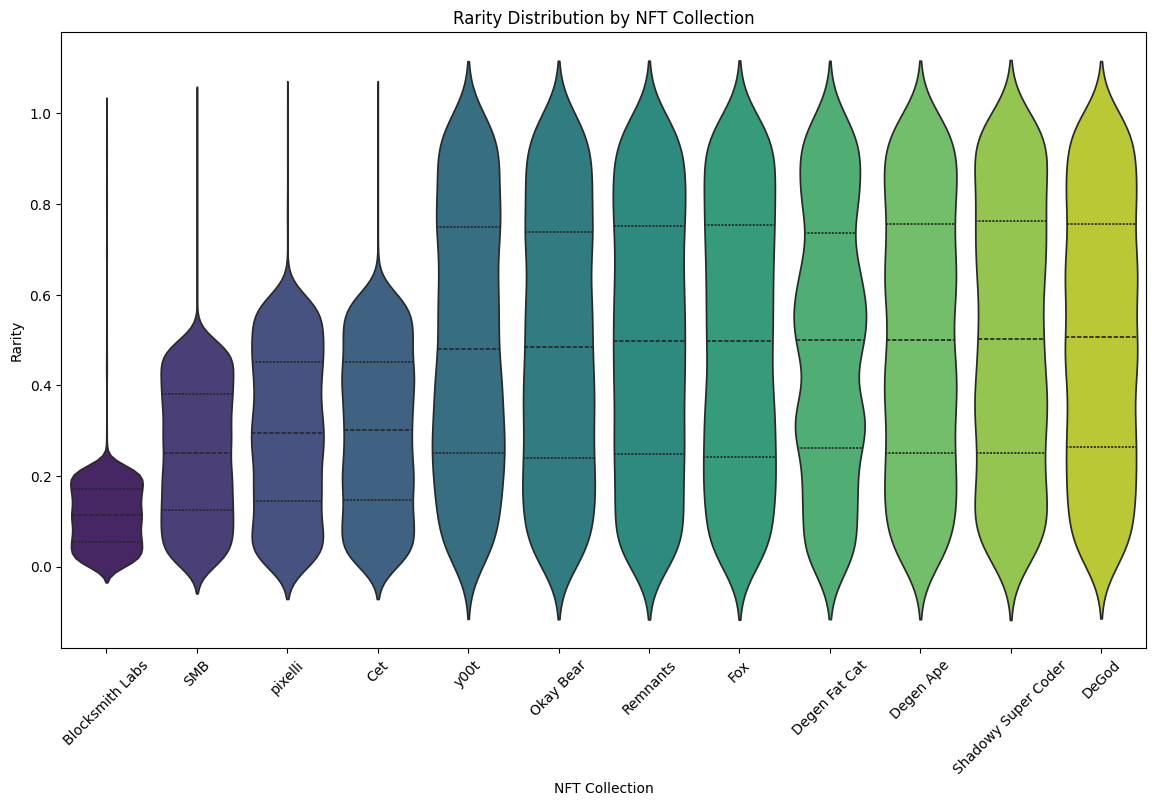

Thresholds for each collection:
collection_name
Blocksmith Labs        0.010655
Cet                    0.027467
DeGod                  0.055192
Degen Ape              0.050695
Degen Fat Cat          0.031714
Fox                    0.045653
Okay Bear              0.046819
Remnants               0.041880
SMB                    0.026505
Shadowy Super Coder    0.055211
pixelli                0.023332
y00t                   0.059032
Name: rarity, dtype: float64


In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a dictionary label_dist with rarity data
# Replace 'label_dist' with the actual dictionary variable
# valid_list is assumed to be a list of collection names

# Create an empty DataFrame to store the data
df = pd.DataFrame(columns=['collection_name', 'rarity'])

# Populate the DataFrame with data from label_dist
for col_name, rarity_values in label_dist.items():
    df = pd.concat([df, pd.DataFrame({'collection_name': [col_name] * len(rarity_values), 'rarity': rarity_values})])

# Create a violin plot to visualize the rarity distribution for each collection
plt.figure(figsize=(14, 8))
sns.violinplot(x='collection_name', y='rarity', data=df, palette="viridis", inner="quartile", order=df.groupby('collection_name')['rarity'].median().sort_values().index)
plt.title('Rarity Distribution by NFT Collection')
plt.xlabel('NFT Collection')
plt.ylabel('Rarity')
plt.xticks(rotation=45)
plt.show()

# Calculate the 5th percentile as a threshold for rare items for each collection
thresholds = df.groupby('collection_name')['rarity'].quantile(0.05)

# Print the thresholds for each collection
print("Thresholds for each collection:")
print(thresholds)

In [131]:
for col_name in col_names:
    new_l = []
    new_l = [x for x in label_dist[col_name] if x <= thresholds[col_name]]
    if len(new_l) > 0:
        print(f"{col_name}: {len(new_l)}:  {sorted(new_l)[0]}")

Shadowy Super Coder: 151:  0.00020004000800160032
pixelli: 150:  0.00012064181445288937
DeGod: 151:  0.0011078658475173733
SMB: 151:  0.00010002000400080016
Degen Ape: 151:  0.0004999500049995
Okay Bear: 151:  0.00040016006402561027
Fox: 151:  0.0001286008230452675
Remnants: 151:  0.00012501562695336918
Cet: 151:  8.664760419374404e-05
y00t: 151:  8.233163181294254e-05
Blocksmith Labs: 151:  5.04999495000505e-05
Degen Fat Cat: 148:  0.0005502476114251413


In [136]:
df = pd.read_csv("old_dataset_rarity.csv")

In [137]:
df['cls_label'] = 0

In [139]:
df

,Unnamed: 0,onChainName,rarity,dict,rank_values_merarity,rank_values_moonrank,label,cls_label
0,0,Shadowy Super Coder #8854,{'merarity': {'tokenKey': 'C7QCcmTJNE5o67uM3XM...,{'merarity': {'tokenKey': 'C7QCcmTJNE5o67uM3XM...,6256.0,6271.0,0.625725,0
1,1,Shadowy Super Coder #8353,{'merarity': {'tokenKey': 'NJDoMZ8sZH9XeyeKvyb...,{'merarity': {'tokenKey': 'NJDoMZ8sZH9XeyeKvyb...,6690.0,6675.0,0.669134,0
2,2,Shadowy Super Coder #8124,{'merarity': {'tokenKey': 'CM8LUzDmvQ9FvgXFN3a...,{'merarity': {'tokenKey': 'CM8LUzDmvQ9FvgXFN3a...,8594.0,8589.0,0.859572,0
3,3,Shadowy Super Coder #2793,{'merarity': {'tokenKey': 'EXhiaHJoKvPHXV1u9wA...,{'merarity': {'tokenKey': 'EXhiaHJoKvPHXV1u9wA...,973.0,973.0,0.097319,0
4,4,Shadowy Super Coder #7298,{'merarity': {'tokenKey': 'BjFBT8sbemnGoRirAsv...,{'merarity': {'tokenKey': 'BjFBT8sbemnGoRirAsv...,3635.0,3630.0,0.363573,0
...,...,...,...,...,...,...,...,...
35947,35995,Degen Fat Cat #17694,{'merarity': {'tokenKey': '5FSmN7Z1rTpVRuiMXkq...,{'merarity': {'tokenKey': '5FSmN7Z1rTpVRuiMXkq...,10878.0,10880.0,0.544145,0
35948,35996,Degen Fat Cat #5841,{'merarity': {'tokenKey': '9BgydnArQggu7LeiDmT...,{'merarity': {'tokenKey': '9BgydnArQggu7LeiDmT...,6716.0,6720.0,0.335951,0
35949,35997,Degen Fat Cat #17893,{'merarity': {'tokenKey': 'v2gw5v2vj4uPrqGGaH6...,{'merarity': {'tokenKey': 'v2gw5v2vj4uPrqGGaH6...,16787.0,16793.0,0.839728,0
35950,35998,Degen Fat Cat #19104,{'merarity': {'tokenKey': '4ErvdC4m4Bf6TyE1GH7...,{'merarity': {'tokenKey': '4ErvdC4m4Bf6TyE1GH7...,3687.0,3691.0,0.184433,0


In [141]:
import pandas as pd

# Assuming df, valid_slice, thresholds, and col_names are defined

for i in range(len(valid_slice) + 1):
    if i == 0:
        df.loc[:valid_slice[i], 'cls_label'] = df['label'][:valid_slice[i]].apply(lambda x: 1 if x <= thresholds[col_names[i]] else 0)
            
    elif i > 0 and i < len(valid_slice):
        df.loc[valid_slice[i-1]:valid_slice[i], 'cls_label'] = df['label'][valid_slice[i-1]:valid_slice[i]].apply(lambda x: 1 if x <= thresholds[col_names[i]] else 0)
    
    else:
        df.loc[valid_slice[i-1]:, 'cls_label'] = df['label'][valid_slice[i-1]:].apply(lambda x: 1 if x <= thresholds[col_names[i]] else 0)

In [143]:
df[df['cls_label']==1.]

,Unnamed: 0,onChainName,rarity,dict,rank_values_merarity,rank_values_moonrank,label,cls_label
13,13,Shadowy Super Coder #152,{'merarity': {'tokenKey': '8YcttovNxg16aoruTLE...,{'merarity': {'tokenKey': '8YcttovNxg16aoruTLE...,404.0,403.0,0.040408,1.0
20,20,Shadowy Super Coder #5595,{'merarity': {'tokenKey': 'Hm5Ntt6jwwzTSNTPXVR...,{'merarity': {'tokenKey': 'Hm5Ntt6jwwzTSNTPXVR...,194.0,194.0,0.019404,1.0
27,27,Shadowy Super Coder #6222,{'merarity': {'tokenKey': 'CAApYq2kx12gS3E3aNX...,{'merarity': {'tokenKey': 'CAApYq2kx12gS3E3aNX...,382.0,382.0,0.038208,1.0
36,36,Shadowy Super Coder #5925,{'merarity': {'tokenKey': '2apZJYRsUTUMzswFPCg...,{'merarity': {'tokenKey': '2apZJYRsUTUMzswFPCg...,414.0,414.0,0.041408,1.0
42,42,Shadowy Super Coder #8840,{'merarity': {'tokenKey': '65Ev1N6q51gbXu4HUQj...,{'merarity': {'tokenKey': '65Ev1N6q51gbXu4HUQj...,27.0,27.0,0.002701,1.0
...,...,...,...,...,...,...,...,...
35861,35909,Degen Fat Cat the 442nd,{'merarity': {'tokenKey': 'EaPMSjMEgp8zBE8d7h2...,{'merarity': {'tokenKey': 'EaPMSjMEgp8zBE8d7h2...,201.0,201.0,0.010055,1.0
35876,35924,Degen Fat Cat #1174,{'merarity': {'tokenKey': 'p5timAJa128uEznwP33...,{'merarity': {'tokenKey': 'p5timAJa128uEznwP33...,631.0,635.0,0.031564,1.0
35880,35928,Degen Fat Cat #13466,{'merarity': {'tokenKey': 'DZ8kfDJShM4NoNT5J6R...,{'merarity': {'tokenKey': 'DZ8kfDJShM4NoNT5J6R...,614.0,618.0,0.030714,1.0
35882,35930,Degen Fat Cat the 431st,{'merarity': {'tokenKey': '3j5AaZzsJzbJyXXNici...,{'merarity': {'tokenKey': '3j5AaZzsJzbJyXXNici...,201.0,201.0,0.010055,1.0


In [145]:
150 * 12

1800